In [26]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import roc_auc_score

import seaborn as sns
sns.set_context("talk")
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import joblib
import time
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score

In [27]:
df = pd.read_csv("../data/junio12.csv",encoding = "ISO-8859-1")
df["FECHA_SINTOMAS"] = pd.to_datetime(df["FECHA_SINTOMAS"], errors="coerce")
df["FECHA_DEF"] = pd.to_datetime(df["FECHA_DEF"], errors="coerce")
df["FECHA_INGRESO"] = pd.to_datetime(df["FECHA_INGRESO"], errors="coerce")
today = date.today()
today

datetime.date(2020, 6, 12)

In [28]:
df_positivos = df[df["RESULTADO"] == 1]

In [29]:
df["FECHA_DEF"].notna()

0          True
1          True
2         False
3         False
4         False
          ...  
381134    False
381135    False
381136    False
381137    False
381138    False
Name: FECHA_DEF, Length: 381139, dtype: bool

In [30]:
corte = 15
df_positivos["anterior_corte"] = (pd.to_datetime(today) - df_positivos["FECHA_SINTOMAS"]).dt.days > corte
df_creibles = df_positivos[(df_positivos["FECHA_DEF"].notnull()) | (df_positivos["anterior_corte"])]
df_creibles.drop("anterior_corte", axis=1, inplace=True)
df_creibles["fallecio"] = df_creibles["FECHA_DEF"].notna()
df_creibles["fallecio"] = df_creibles["fallecio"].astype(int)

df_creibles = df_creibles.drop(["FECHA_ACTUALIZACION", 
              "ID_REGISTRO", 
              'FECHA_INGRESO', 
              'FECHA_SINTOMAS',
              'FECHA_DEF',
              'ORIGEN',
              'SECTOR',
              'ENTIDAD_UM',
              'ENTIDAD_NAC',
              'ENTIDAD_RES',
              'MUNICIPIO_RES',
              'TIPO_PACIENTE',
              'NACIONALIDAD',
              'HABLA_LENGUA_INDIG',
              'RESULTADO',
              'MIGRANTE',
              'PAIS_NACIONALIDAD',
              'PAIS_ORIGEN',
              'INTUBADO',
              'UCI',
              'OTRO_CASO'], axis=1)

df_creibles.head()
# df["fallecio"].value_counts()

<ipython-input-30-fc149d9d0452>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positivos["anterior_corte"] = (pd.to_datetime(today) - df_positivos["FECHA_SINTOMAS"]).dt.days > corte
/home/davinchi/Documents/covid19/tarea 5/venv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-30-fc149d9d0452>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,SEXO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,fallecio
0,2,2,61,97,1,2,2,2,2,2,2,1,2,2,1
1,1,2,66,2,2,2,1,2,2,2,2,2,2,2,1
2,2,2,38,97,2,2,2,2,2,2,2,2,2,1,0
3,2,2,82,97,2,2,2,2,1,2,1,2,2,2,0
4,2,2,47,97,2,2,2,2,2,2,2,2,2,2,0


In [31]:
df_creibles["fallecio"].value_counts()

0    95009
1    15944
Name: fallecio, dtype: int64

In [32]:
def plot_cm(y_test, y_pred, normalize=None):
    # values: dict of prediction {"0": "Not fraud", "1":"Fraud"}
    
    cm = np.round(confusion_matrix(y_test, y_pred, normalize=normalize),4)
    
    plt.figure()
    ax = sns.heatmap(cm,annot=True, xticklabels=["No falleció", "falleció"],yticklabels=["No falleció", "falleció"])

    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title("Confussion matrix", fontsize = 15)

    plt.show()

In [33]:
df_creibles.columns

Index(['SEXO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'fallecio'],
      dtype='object')

In [34]:
categoricas = ['SEXO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'fallecio']

for col in categoricas:
    df_creibles[col] = df_creibles[col].astype('category')

In [35]:
df_creibles[df_creibles.duplicated()]

,SEXO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,fallecio
63,2,2,38,97,2,2,2,2,2,2,2,2,2,2,0
82,2,2,52,97,2,2,2,2,2,2,2,2,2,2,0
85,1,2,35,2,2,2,2,2,2,2,2,1,2,2,0
87,1,2,41,2,2,2,2,2,1,2,2,2,2,2,0
93,1,2,50,2,2,2,2,2,2,2,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133969,2,2,38,97,2,2,2,2,2,2,2,2,2,2,0
133970,2,2,45,97,2,2,2,2,2,2,2,2,2,2,0
133971,2,1,38,97,2,2,2,2,2,2,2,2,2,2,0
133972,1,2,37,2,2,2,2,2,1,2,2,2,2,1,0


In [36]:
df_creibles.dtypes

SEXO              category
NEUMONIA          category
EDAD                 int64
EMBARAZO          category
DIABETES          category
EPOC              category
ASMA              category
INMUSUPR          category
HIPERTENSION      category
OTRA_COM          category
CARDIOVASCULAR    category
OBESIDAD          category
RENAL_CRONICA     category
TABAQUISMO        category
fallecio          category
dtype: object

In [37]:
X = df_creibles.drop("fallecio", axis=1)
y = df_creibles["fallecio"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0, stratify=y)
print(X_train.shape)
print(X_test.shape)

(88762, 14)
(22191, 14)


In [53]:
cb_clf = CatBoostClassifier(cat_features=['SEXO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO'], class_weights = [0.2, 0.8])

In [54]:
cb_clf.fit(X_train, y_train)

Learning rate set to 0.069956
0:	learn: 0.6499227	total: 71.8ms	remaining: 1m 11s
1:	learn: 0.6143484	total: 157ms	remaining: 1m 18s
2:	learn: 0.5873552	total: 222ms	remaining: 1m 13s
3:	learn: 0.5614542	total: 296ms	remaining: 1m 13s
4:	learn: 0.5400732	total: 375ms	remaining: 1m 14s
5:	learn: 0.5226565	total: 452ms	remaining: 1m 14s
6:	learn: 0.5084311	total: 527ms	remaining: 1m 14s
7:	learn: 0.4971793	total: 588ms	remaining: 1m 12s
8:	learn: 0.4868673	total: 688ms	remaining: 1m 15s
9:	learn: 0.4772656	total: 793ms	remaining: 1m 18s
10:	learn: 0.4694093	total: 878ms	remaining: 1m 18s
11:	learn: 0.4630420	total: 970ms	remaining: 1m 19s
12:	learn: 0.4574467	total: 1.04s	remaining: 1m 19s
13:	learn: 0.4528686	total: 1.16s	remaining: 1m 21s
14:	learn: 0.4492389	total: 1.26s	remaining: 1m 22s
15:	learn: 0.4459428	total: 1.37s	remaining: 1m 24s
16:	learn: 0.4426695	total: 1.48s	remaining: 1m 25s
17:	learn: 0.4398410	total: 1.58s	remaining: 1m 26s
18:	learn: 0.4374637	total: 1.67s	remaining

In [55]:
y_pred = cb_clf.predict(X_test)
y_scores = cb_clf.predict_proba(X_test)[:,1]

In [56]:
roc_auc_score(y_test, y_scores)

0.8786808317019921

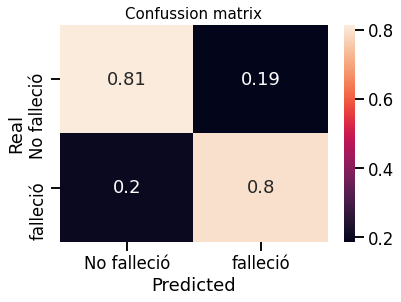

In [57]:
plot_cm(y_test, y_pred, normalize="true")

In [162]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = f'lgbm_{timestr}.pkl'
joblib.dump(lgbm_clf, filename)

['lgbm_20200612-130123.pkl']